In [1]:
# !pip install cplex
# !pip install docplex
from docplex.mp.model import Model
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.optimize import minimize
import scienceplots
import lovelyplots

In [2]:
def build_interactions(qubit_frequencies):
    """Generate all interaction frequencies from a list of qubit frequencies."""
    interaction_freqs = []
    for i in range(len(qubit_frequencies) - 1):
        for j in range(i + 1, len(qubit_frequencies)):
            interaction_freqs.append(abs(qubit_frequencies[j] - qubit_frequencies[i]))
    return interaction_freqs


def min_separation(values):
    """Calculate the minimum separation between values."""
    if len(values) > 1:
        sorted_values = np.sort(values)
        return np.min(np.diff(sorted_values))
    return 0

In [3]:
from docplex.mp.model import Model


def maximize_distinct_interaction_separation_lp(
    N, var_low=4e9, var_high=6e9, Delta_Q=None
):
    """Optimize using LP to maximize the minimum difference between interaction frequencies,
    with an optional constraint on minimum qubit frequency separation (Delta_Q), and enforce ordering of qubit frequencies.
    """
    model = Model(name="Maximize_Min_Interaction_Difference")
    qubit_freqs = model.continuous_var_list(N, lb=var_low, ub=var_high, name="q")

    # Calculate interaction differences for each pair of qubit frequencies
    interaction_diffs = [
        model.abs(qubit_freqs[j] - qubit_freqs[i])
        for i in range(N)
        for j in range(i + 1, N)
    ]
    min_diff = model.continuous_var(lb=0, name="min_diff")

    # Enforce that the minimum difference is less than the difference between each interaction pair
    model.add_constraints(
        min_diff <= model.abs(interaction_diffs[i] - interaction_diffs[j])
        for i in range(len(interaction_diffs))
        for j in range(i + 1, len(interaction_diffs))
    )

    # Enforce ordering and optional minimum separation between qubit frequencies
    for i in range(N - 1):
        model.add_constraint(qubit_freqs[i] <= qubit_freqs[i + 1])  # Enforce ordering
        if Delta_Q is not None:
            model.add_constraint(
                qubit_freqs[i] + Delta_Q <= qubit_freqs[i + 1]
            )  # Enforce min separation if specified

    # Objective: maximize the minimum interaction difference
    model.maximize(min_diff)

    # Solve the model
    solution = model.solve()
    if solution:
        return min_diff.solution_value / 1e6  # Convert Hz to MHz
    else:
        return 0

In [4]:
def maximize_distinct_interaction_separation_numerical(
    N, var_low=4, var_high=6, iterations=16
):
    """Optimize using numerical methods with multiple restarts."""
    best_min_sep = 0
    for _ in range(iterations):
        initial_guess = np.random.uniform(var_low, var_high, N)
        result = minimize(
            lambda x: -min_separation(build_interactions(x)),
            initial_guess,
            bounds=[(var_low, var_high)] * N,
            method="L-BFGS-B",
        )

        if result.success:
            optimized_freqs = result.x
            optimized_interactions = build_interactions(optimized_freqs)
            min_sep = (
                min_separation(optimized_interactions) * 1000
            )  # Convert GHz to MHz
            if min_sep > best_min_sep:
                best_min_sep = min_sep
    return best_min_sep

In [5]:
# Golomb ruler marks for small values of n based on A003022
golomb_ruler_marks = {
    2: [0, 1],
    3: [0, 1, 3],
    4: [0, 1, 4, 6],
    5: [0, 1, 4, 9, 11],
    6: [0, 1, 4, 10, 12, 17],
    7: [0, 1, 4, 10, 18, 23, 25],
    # Extend with more values from A003022 as needed
}


def analytical_sequence(N, var_low=4, var_high=6):
    """Generate a frequency sequence based on Golomb ruler marks for unique pairwise differences."""
    if N not in golomb_ruler_marks:
        raise ValueError("Golomb ruler marks not available for N = {}".format(N))

    # Retrieve the Golomb ruler positions for the specified N
    marks = np.array(golomb_ruler_marks[N])
    marks = marks - marks.min()  # Normalize to start at 0
    marks = marks / marks.max()  # Normalize to range [0, 1]

    # Scale to fit within [var_low, var_high]
    freqs = var_low + marks * (var_high - var_low)
    return freqs


def analytical_cost(N):
    freqs = analytical_sequence(N)
    interaction_freqs = build_interactions(freqs)
    return min_separation(interaction_freqs) * 1000  # Convert GHz to MHz

In [ ]:
# Parameters
N_values = range(3, 7)  # Limit LP to N <= 6
lp_results = []
for N in tqdm(N_values):
    # LP Optimization
    lp_min_diff = maximize_distinct_interaction_separation_lp(N)
    lp_results.append(lp_min_diff)


# Parameters
N1_values = range(3, 8)  # Limit LP to N <= 6
numerical_results = []
for N in tqdm(N1_values):
    # Numerical Optimization
    numerical_min_diff = maximize_distinct_interaction_separation_numerical(N)
    numerical_results.append(numerical_min_diff)


# Parameters
N1_values = range(3, 8)
analytical_results = []

for N in tqdm(N1_values):
    # Analytical approximation
    analytical_min_diff = analytical_cost(N)
    analytical_results.append(analytical_min_diff)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Define parameters
delta_q = np.linspace(0, 500e6, 24)  # Range for Delta_Q in Hz
N2_values = [3, 4, 5, 6]  # Values for different qubit counts
lp_results_delta_q_all = {}  # Store results for each N

# Collect LP results for different Delta_Q and N values
for N in N2_values:
    lp_results_delta_q = []
    for dq in tqdm(delta_q):
        lp_results_delta_q.append(
            maximize_distinct_interaction_separation_lp(N=N, Delta_Q=dq)
        )
    lp_results_delta_q_all[N] = lp_results_delta_q

# Calculate analytical Golomb costs
analytical_costs = {N: analytical_cost(N) for N in N2_values}

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

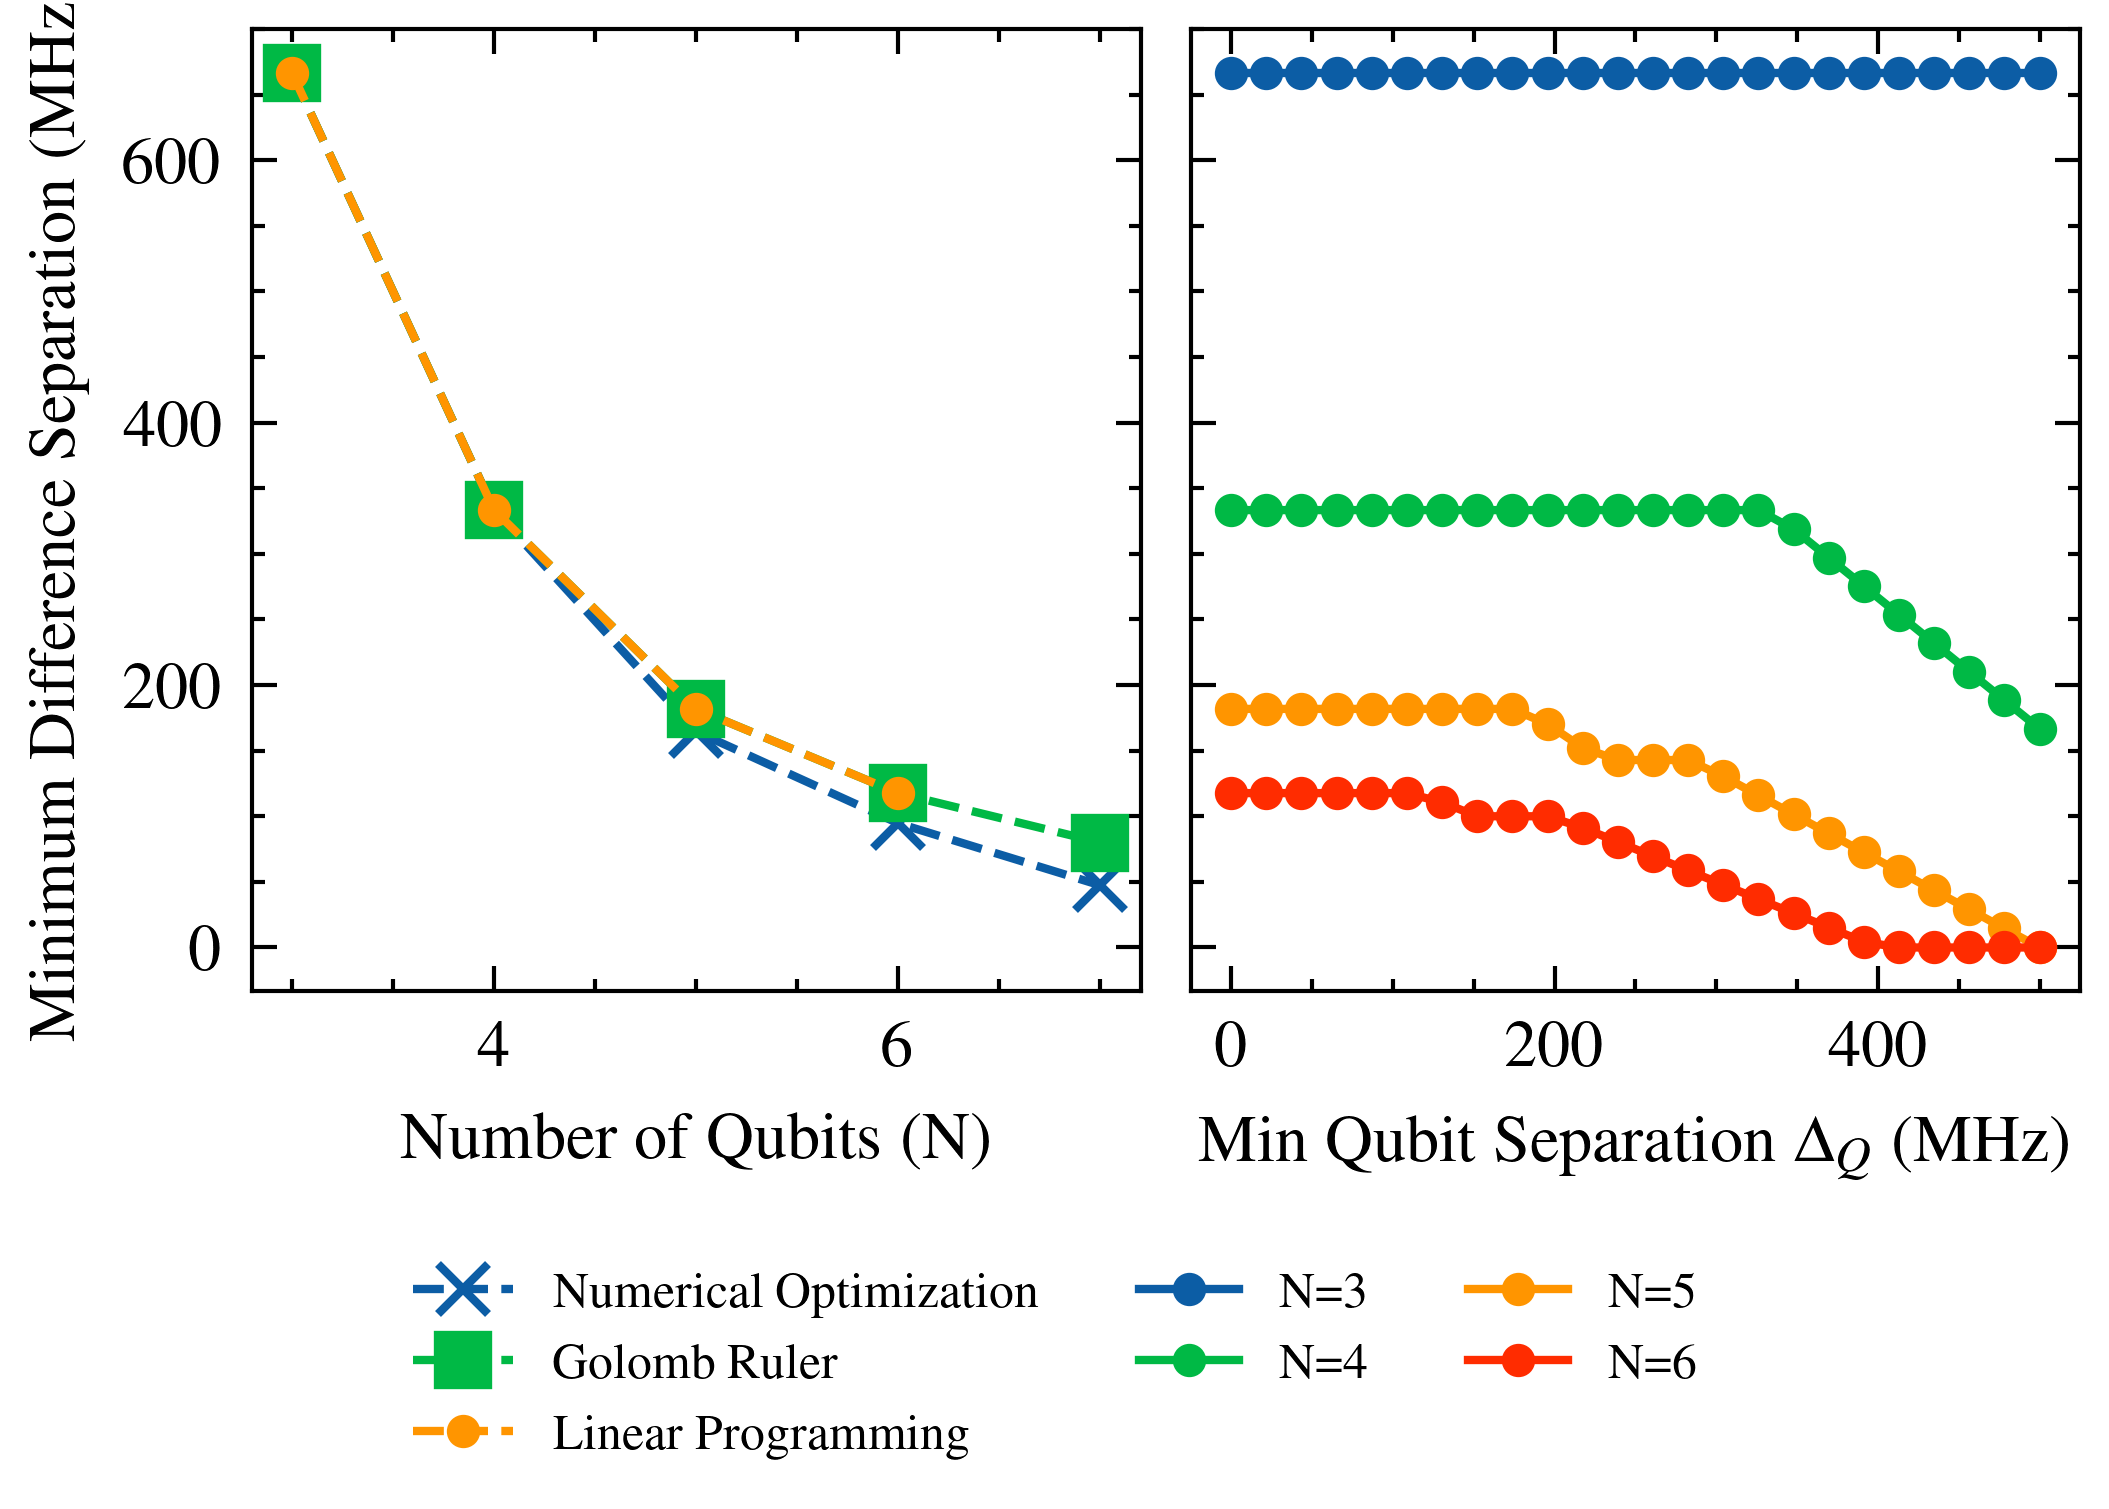

In [41]:
import matplotlib.pyplot as plt
import scienceplots
import lovelyplots

with plt.style.context(["ieee", "use_mathtext", "science"]):
    fig, axs = plt.subplots(
        1, 2, sharey=True, figsize=(3.5, 2), constrained_layout=True
    )

    # Left subplot: Golomb vs. Numerical & LP
    ax = axs[0]
    (line1,) = ax.plot(
        N1_values,
        numerical_results,
        marker="x",
        linestyle="--",
        label="Numerical Optimization",
    )
    (line2,) = ax.plot(
        N1_values, analytical_results, marker="s", linestyle="--", label="Golomb Ruler"
    )
    (line3,) = ax.plot(
        N1_values[: len(lp_results)],
        lp_results,
        marker=".",
        linestyle="--",
        label="Linear Programming",
    )
    ax.set_xlabel("Number of Qubits (N)")
    ax.set_ylabel("Minimum Difference Separation (MHz)")  # Shared y-axis
    ax.grid(False)  # Disable the default background grid

    # Right subplot: LP results vs. Min Qubit Separation
    ax = axs[1]
    lp_lines = []
    for N in N2_values:
        (line,) = ax.plot(
            delta_q / 1e6,  # Convert to MHz
            lp_results_delta_q_all[N],
            marker=".",
            label=f"N={N}",
        )
        lp_lines.append(line)

    ax.set_xlabel(r"Min Qubit Separation $\Delta_Q$ (MHz)")
    ax.grid(False)  # Disable the default background grid

    # Collect all legend handles and labels
    handles = [line1, line2, line3] + lp_lines
    labels = [h.get_label() for h in handles]

    # Create a single legend at the bottom of the figure
    fig.legend(
        handles,
        labels,
        loc="lower center",
        ncol=3,  # Arrange in 3 columns for better spacing
        fontsize=6,
        bbox_to_anchor=(0.5, -0.25),  # Move it below the x-axis
    )

    # Show and save the figure
    plt.show()
    fig.savefig(
        "../../img/interaction_separation_side_by_side.pdf", bbox_inches="tight"
    )

In [10]:
# # Initialize parameters
# var_low = 4e9  # Lower bound of qubit frequencies (in Hz)
# var_high = 6e9  # Upper bound of qubit frequencies (in Hz)


# def solve_model_with_delta(delta_Q_2, Delta_Q, N):
#     """Solve the model for a given delta_Q^(2) and return the solution and differences if it exists."""
#     # Create a new model using DOcplex MP
#     model = Model(name="maximize_qubit_interaction_separation")

#     # Define qubit frequencies (continuous variables between var_low and var_high)
#     qubit_freqs = model.continuous_var_list(N, lb=var_low, ub=var_high, name="q")

#     # Enforce that qubit frequencies are in increasing order and have a minimum separation of Delta_Q
#     for i in range(N - 1):
#         model.add_constraint(qubit_freqs[i] + Delta_Q <= qubit_freqs[i + 1])

#     # Define a list to store the interaction frequency separations (delta_Q^(2)) for all possible pairs
#     interaction_diffs = []
#     for i in range(N):
#         for j in range(i + 1, N):
#             interaction_diffs.append(qubit_freqs[j] - qubit_freqs[i])

#     # Now, add constraints to ensure abs(delta_Q^(2)_i - delta_Q^(2)_j) >= delta_Q_2 for all pairs of interaction separations
#     for i in range(len(interaction_diffs)):
#         for j in range(i + 1, len(interaction_diffs)):
#             model.add_constraint(
#                 model.abs(interaction_diffs[i] - interaction_diffs[j]) >= delta_Q_2
#             )

#     # Solve the model
#     solution = model.solve()

#     # Return the solution and interaction frequency separations if the solution exists
#     if solution:
#         qubit_values = [qubit_freqs[i].solution_value for i in range(N)]
#         interaction_values = sorted([diff.solution_value for diff in interaction_diffs])
#         return True, qubit_values, interaction_values
#     else:
#         return False, None, None


# def binary_search_delta(min_delta, max_delta, Delta_Q, N, tol=1e-3):
#     """Perform a binary search to find the maximum delta_Q^(2) for which a solution exists."""
#     best_delta_Q_2 = min_delta

#     while max_delta - min_delta > tol:
#         mid_delta = (min_delta + max_delta) / 2
#         solution_exists, _, _ = solve_model_with_delta(mid_delta, Delta_Q, N)

#         if solution_exists:
#             best_delta_Q_2 = (
#                 mid_delta  # This is a valid solution, so we update the best delta_Q_2
#             )
#             min_delta = mid_delta  # Try larger delta_Q_2
#         else:
#             max_delta = mid_delta  # Try smaller delta_Q_2

#     return best_delta_Q_2


# def collect_data_for_N_values(N_values, Delta_Q_range):
#     """Collects the data for different values of N and Delta_Q."""
#     results = {}

#     # Loop over different values of N
#     for N in N_values:
#         # Store the best delta_Q^(2) values for each Delta_Q
#         best_delta_Q_2_values = []

#         # Perform binary search for each Delta_Q to find the best delta_Q^(2)
#         for Delta_Q in tqdm(Delta_Q_range):
#             best_delta_Q_2 = binary_search_delta(
#                 0.0, (var_high - var_low) / (N - 1), Delta_Q, N
#             )
#             # Only append the result if a solution exists (best_delta_Q_2 > 0)
#             if best_delta_Q_2 > 0:
#                 best_delta_Q_2_values.append((Delta_Q, best_delta_Q_2))

#         # Store results for this N
#         if best_delta_Q_2_values:
#             results[N] = best_delta_Q_2_values

#     return results

In [11]:
# num_qubits = [4, 5, 6]
# Delta_Q_range = np.linspace(100e6, 600e6, 32)
# results = collect_data_for_N_values(num_qubits, Delta_Q_range)

In [12]:
# def plot_results(results):
#     """Plots the data stored in results with a consistent style."""
#     # Plot the results using consistent style
#     with plt.style.context(
#         ["ieee", "use_mathtext", "science"]
#     ):  # Using consistent style context
#         fig, ax1 = plt.subplots()  # Adjust figure size

#         # Loop over each set of results to plot separate lines for different N values
#         for N, data in results.items():
#             # Extract Delta_Q and delta_Q^(2) where solution exists
#             Delta_Q_values, best_delta_Q_2_plot = zip(*data)

#             # Plotting delta_Q^(2) vs Delta_Q, converting units to GHz and MHz
#             ax1.plot(
#                 np.array(Delta_Q_values) / 1e6,  # Convert Delta_Q to GHz
#                 np.array(best_delta_Q_2_plot) / 1e6,  # Convert delta_Q^(2) to MHz
#                 marker="o",
#                 label=f"N={N}",
#             )

#         # Labels for the main plot
#         ax1.set_xlabel(
#             r"Minimum $\Delta_Q$ (MHz)",
#             fontsize=12,
#             labelpad=-0.25,
#         )
#         ax1.set_ylabel(
#             r"Maximum $\delta_Q^{(2)}$ (MHz)",
#             fontsize=12,
#         )
#         # ax1.set_title(
#         #     r"Maximum $\delta_Q^{(2)}$ (MHz) vs $\Delta_Q$ (GHz) for Different N",
#         #     fontsize=16,
#         # )

#         # Grid, legend, and layout adjustments
#         ax1.grid(True)
#         ax1.legend(
#             fontsize=12,
#             # title="\# of qubits",
#             title_fontsize=12,
#             loc="upper center",
#             ncols=3,
#             bbox_to_anchor=(0.5, -0.15),
#         )
#         fig.tight_layout()

#         # less tick marks on the edges
#         ax1.locator_params(axis="x", nbins=6)
#         ax1.locator_params(axis="y", nbins=6)

#         # Save the plot as an SVG file
#         plot_filename = "../../img/delta_vs_Separation.pdf"
#         plt.savefig(plot_filename)
#         print(f"Saved: {plot_filename}")
#         plt.show()


# # Plot the results with consistent style
# plot_results(results)

In [13]:
# var_low = 4e9  # Lower bound of qubit frequencies (in Hz)
# var_high = 5e9  # Upper bound of qubit frequencies (in Hz)
# ret = solve_model_with_delta(150e6, 180e6, 4)
# print(ret)
# qubits = np.array(ret[1]) / 1e9
# print(qubits)
# # print all pairs of qubit differences
# convs = np.array(ret[2]) / 1e9
# print(convs)

In [14]:
# var_low = 4e9  # Lower bound of qubit frequencies (in Hz)
# var_high = 6e9  # Upper bound of qubit frequencies (in Hz)
# ret = solve_model_with_delta(200e6, 450e6, 4)
# print(ret)
# qubits = np.array(ret[1]) / 1e9
# print(qubits)
# # print all pairs of qubit differences
# convs = np.array(ret[2]) / 1e9
# print(convs)

In [15]:
# ret = solve_model_with_delta(180e6, 100e6, 5)
# print(ret)
# qubits = np.array(ret[1]) / 1e9
# print(qubits)
# # print all pairs of qubit differences
# convs = np.array(ret[2]) / 1e9
# print(convs)